#### Get the credentials from [apps.twitter.com](apps.twitter.com)
Create an app <br>
Click on details tab of app <br>
Copy the sercet and api key to notebook<br>

In [1]:
import twitter
consumer_key = "insert here"
consumer_secret = "insert here"
access_token = "insert here"
access_token_secret = "insert here"
authorization = twitter.OAuth(access_token, access_token_secret, consumer_key, consumer_secret)
t = twitter.Twitter(auth=authorization, retry=True)

In [2]:
import os
import json
data_folder = os.path.join("data", "twitter")
output_filename = os.path.join(data_folder, "python_tweets.json")

In [3]:
original_users = []
tweets = []
user_ids = {}

for i in range(10):
    search_results = t.search.tweets(q="python", count=100)['statuses']
    for tweet in search_results:
        if 'text' in tweet:
            original_users.append(tweet['user']['screen_name'])
            user_ids[tweet['user']['screen_name']] = tweet['user']['id']
            tweets.append(tweet['text'])

In [4]:
model_filename = os.path.join(data_folder, "model", "python_context.pkl")

In [5]:
from sklearn.base import TransformerMixin
from nltk import word_tokenize
from sklearn.feature_extraction import DictVectorizer

class NLTKBOW(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [{word: True for word in word_tokenize(document)}
                 for document in X]

In [6]:
import joblib
context_classifier = joblib.load(model_filename)

In [7]:
y_pred = context_classifier.predict(tweets)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [8]:
relevant_tweets = [tweets[i] for i in range(len(tweets)) if y_pred[i] == 1]
relevant_users = [original_users[i] for i in range(len(tweets)) if y_pred[i] == 1]
print(len(relevant_tweets))

133


In [9]:
import time
import sys

def get_friends(t, user_id):
    friends = []
    cursor = -1
    while cursor != 0:  # If zero, that is the end:
        try:
            results = t.friends.ids(user_id=user_id, cursor=cursor, count=5000)
            friends.extend([friends for friends in results['ids']])
            cursor = results['next_cursor']
            if len(friends) >= 10000:
                break
            if cursor != 0:
                print("Collected {} friends so far, but there are more".format(len(friends)))
        except TypeError as e:
            if results is None:
                print("Reached API limit, waiting for 5 minutes")
                time.sleep(5*60) # 5 minute wait
            else:
                raise e
        except twitter.TwitterHTTPError as e:
            break
        finally:
            time.sleep(60)  # Wait 1 minute before continuing
    return friends


In [ ]:
friends = {}
for screen_name in relevant_users:
    print("Obtaining friends for user {}".format(screen_name))
    user_id = user_ids[screen_name]
    friends[user_id] = get_friends(t, user_id)
friends = {user_id:friends[user_id] for user_id in friends
             if len(friends[user_id]) > 0}

In [ ]:
friends_filename = os.path.join(data_folder, "python_friends.json")

In [ ]:
with open(friends_filename,'w') as outfile:
    json.dump(friends,outfile)

In [11]:
friends_filename = os.path.join(data_folder, "python_friends.json")
with open(friends_filename) as inf:
    friends = json.load(inf)

In [12]:
from collections import defaultdict

In [13]:
def count_friends(friends):
    friend_count = defaultdict(int)
    for friend_list in friends.values():
        for friend in friend_list:
            friend_count[friend] += 1
    return friend_count

In [14]:
friend_count = count_friends(friends)

In [15]:
from operator import itemgetter
best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)

In [16]:
best_friends[:10]

[(822215673812119553, 63),
 (11348282, 59),
 (9624742, 55),
 (822215679726100480, 54),
 (15647676, 53),
 (16669075, 51),
 (76348185, 50),
 (14615871, 49),
 (66369181, 47),
 (61853389, 47)]

In [17]:
len(friends)

90

In [18]:
friends_filename = os.path.join(data_folder, "python_friends.json")
while len(friends) < 150:
    # Get the best friend that isn't already in our list
    for user_id, count in best_friends:
        if user_id not in friends:
            break
    print("Getting friends of user {}".format(user_id))
    friends[user_id] = get_friends(t, user_id)
    print("Received {} friends".format(len(friends[user_id])))
    print("We now have the friends of {} users".format(len(friends)))
    # Update friend_count
    for friend in friends[user_id]:
        friend_count[friend] += 1
    # Update the best friends list
    with open(friends_filename, 'w') as outf:
        json.dump(friends, outf)
    best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)

In [19]:
import json
friends_filename = os.path.join(data_folder, "python_friends.json")
with open(friends_filename, 'w') as outf:
    json.dump(friends, outf)

In [25]:
import networkx as nx
G = nx.DiGraph()

main_users = friends.keys()
G.add_nodes_from(main_users)
count =0
for user_id in friends:
    for friend in friends[str(user_id)]:
        if str(friend) in main_users:
            count+=1
            G.add_edge(user_id, friend) 
G

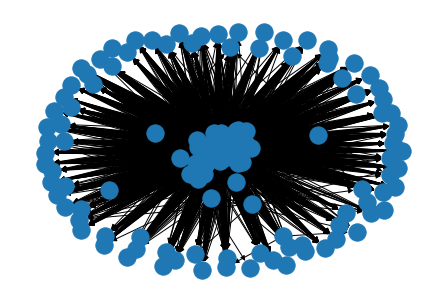

In [26]:
%matplotlib inline
nx.draw(G)

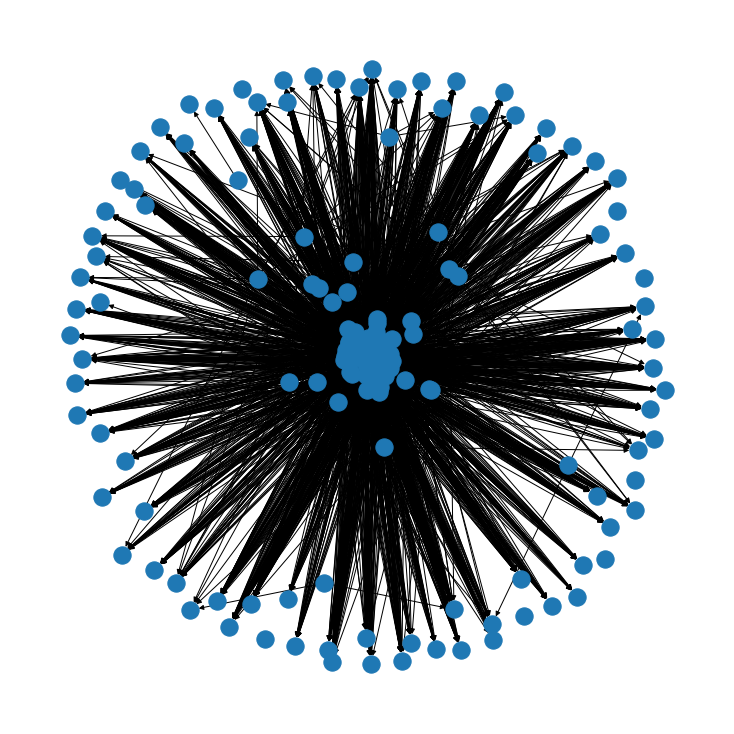

In [27]:
from matplotlib import pyplot as plt
plt.figure(3,figsize=(10, 10))
nx.draw(G)